Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4008 - loss: 0.7038 - val_accuracy: 0.4931 - val_loss: 0.6923
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4644 - loss: 0.7046 - val_accuracy: 0.6538 - val_loss: 0.6727
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5171 - loss: 0.7014 - val_accuracy: 0.5244 - val_loss: 0.6893
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6161 - loss: 0.6717 - val_accuracy: 0.3837 - val_loss: 0.7132
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4812 - loss: 0.6848 - val_accuracy: 0.4000 - val_loss: 0.7161
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4889 - loss: 0.6902 - val_accuracy: 0.5575 - val_loss: 0.6811
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5784 - loss: 0.6827 - val_accuracy: 0.4238 - val_loss: 0.7117
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5351 - loss: 0.6724 - val_accuracy: 0.4181 - val_

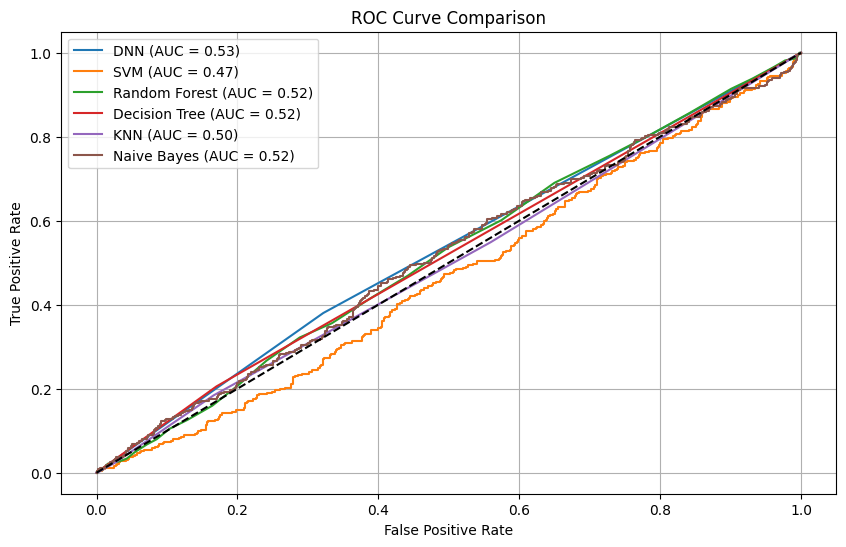

Model AUC Scores:
SVM: 0.4678
Random Forest: 0.5186
Decision Tree: 0.5176
KNN: 0.5001
Naive Bayes: 0.5154
DNN: 0.5292


In [1]:
# Install required libraries
!pip install tensorflow scikit-learn pandas matplotlib

# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load dataset
df = pd.read_csv('/content/synthetic_lung_cancer_dataset.csv')

# Preprocess categorical variables
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['Chronic Respiratory Diseases'] = df['Chronic Respiratory Diseases'].fillna('None')
df['Chronic Respiratory Diseases'] = LabelEncoder().fit_transform(df['Chronic Respiratory Diseases'])
df['Cancer Stage'] = LabelEncoder().fit_transform(df['Cancer Stage'])

# Environmental and biomarker features
E_cols = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'VOCs (ppb)', 'CO (ppm)', 'NO2 (ppm)', 'SO2 (ppm)',
          'Temperature (°C)', 'Humidity (%)', 'Tobacco Smoke Exposure']
B_cols = ['SpO2 (%)', 'Resting Heart Rate (bpm)', 'Respiratory Rate (breaths/min)', 'FeNO (ppb)',
          'Exhaled VOC Biomarkers (ppb)', 'Blood Sugar Level (mg/dL)']

# Normalize & PCA
scaler = MinMaxScaler()
D_scaled = scaler.fit_transform(df[E_cols + B_cols])
pca = PCA(n_components=0.95)
D_pca = pca.fit_transform(D_scaled)

# Labels
y = df['Chest X-ray/CT Scan Results']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(D_pca, y, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# DNN Model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2,
                    class_weight=class_weights_dict, verbose=1)

# DNN Predictions
y_pred_dnn = (model.predict(X_test) > 0.5).astype(int)
dnn_auc = roc_auc_score(y_test, y_pred_dnn)

# Classical models
models = {
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

results = {}
for name, model_ in models.items():
    model_.fit(X_train, y_train)
    preds = model_.predict(X_test)
    probas = model_.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probas)
    results[name] = {
        "Classification Report": classification_report(y_test, preds, zero_division=0),
        "AUC": auc,
        "Probas": probas
    }

# ROC Plot
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_dnn)
plt.plot(fpr, tpr, label=f"DNN (AUC = {dnn_auc:.2f})")
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["Probas"])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Print summary AUCs
print("Model AUC Scores:")
for name, res in results.items():
    print(f"{name}: {res['AUC']:.4f}")
print(f"DNN: {dnn_auc:.4f}")
